In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from projection_testing import test_projection, viz_projection
from mrobotics.piecewise.cubic import cubic_interpolating_curve
from mrobotics.piecewise.waypoints_maker import gen_arc_points

# Define the test case

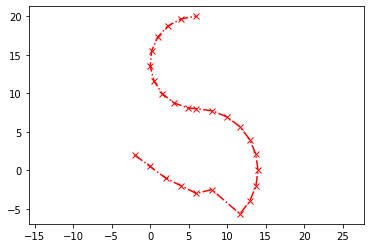

In [2]:
r1 = 8.0
r2 = 6.0
my_waypoints = np.array([
    [-2.0,2.0],
    [0.0,0.5],
    [2.0,-1.0],
    [4.0, -2.0],
    [6.0, -3.0],
    [8.0, -2.5],  # <--- ends at 6
    *gen_arc_points(xy_center=[6,0],radius=r1, start_radian=-np.pi/4,  stop_radian=np.pi/2, N_samples=10), # ends at 16
    *gen_arc_points(xy_center=[6,r1+r2],radius=r2, start_radian=np.pi*1.5,  stop_radian=np.deg2rad(100))
])
plt.plot(*my_waypoints.T,'-.xr')
plt.axis('equal')
plt.show()

In [3]:
my_curve = cubic_interpolating_curve(my_waypoints)

# Very basic: zeroth-order

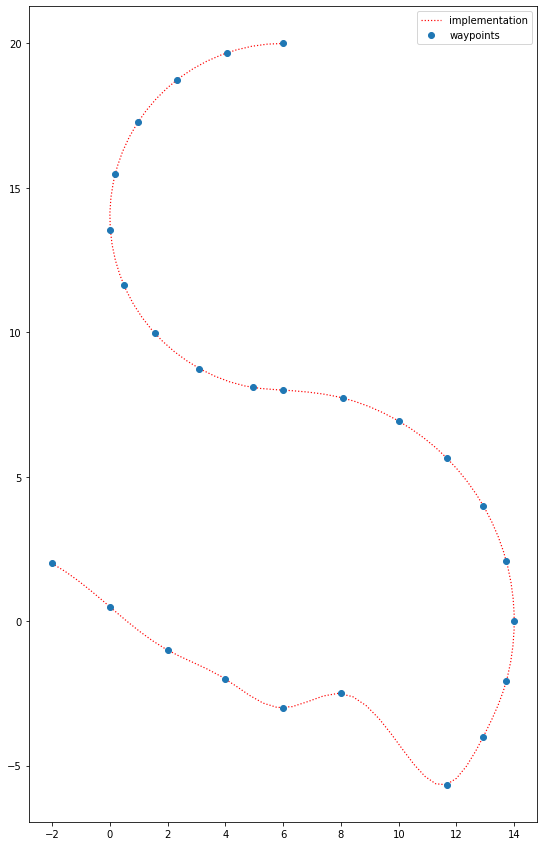

In [4]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
pts_test = my_curve.get_pos(t_eval)
_, ax = plt.subplots(figsize=(12,15))
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation')
ax.plot(*my_waypoints.T, 'o', label='waypoints')
ax.set_aspect('equal')
ax.legend()
plt.show()

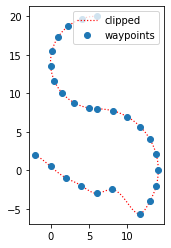

In [5]:
# what about extrapolation?
t_eval = np.linspace(my_curve.idx2arclen[0]-2, my_curve.idx2arclen[-1]+2,100) 
pts_test = my_curve.get_pos(my_curve.clip(t_eval)) #<--- clipped
_, ax = plt.subplots()
ax.plot(*pts_test.T, ':r',lw=1.2, label='clipped')
ax.plot(*my_waypoints.T, 'o', label='waypoints')
ax.set_aspect('equal')
ax.legend()
plt.show()

# First-order
* correctness of the unit tangent?
* let's see how bad/good the approximate arc-length parameterization is --- speed wrt path parameter

In [6]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
pts_test = my_curve.get_utang(t_eval)
np.testing.assert_allclose(np.linalg.norm(pts_test, axis=1, ord=2) ,1.0)

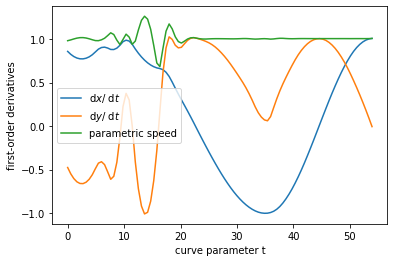

In [7]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
velocity = my_curve.get_tang(t_eval)
plt.plot(t_eval, velocity[:,0], label="d$x$/ d$t$")
plt.plot(t_eval, velocity[:,1], label="d$y$/ d$t$")
plt.plot(t_eval, np.linalg.norm(velocity,axis=1,ord=2), label="parametric speed")
plt.xlabel('curve parameter t')
plt.ylabel('first-order derivatives')
plt.legend()
plt.show()

# Second-order
We will only look at the curvature values

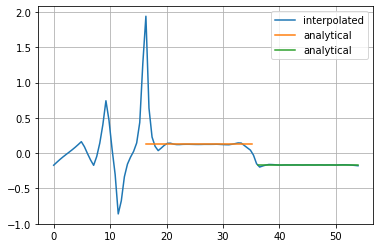

In [8]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
velocity = my_curve.get_tang(t_eval)
velocity2, k = my_curve.get_tang_and_curv(t_eval)
np.testing.assert_allclose(velocity, velocity2)

plt.plot(t_eval, k, label='interpolated')
plt.plot([my_curve.idx2arclen[6],my_curve.idx2arclen[15]], [1/r1, 1/r1], label='analytical')
plt.plot([my_curve.idx2arclen[16],my_curve.idx2arclen[-1]], [-1/r2, -1/r2], label='analytical')
plt.grid('both')
plt.legend()
plt.show() # does the last part (the circular arc) has the expected sign and curvature (expected to be approximately 1/radius) ?



# Estimating progress along the path

* Does the `project` method inherited from the waypoint superclass still works good enough?

## Testing cases 1a and 1b

Now, we are testing some query points around the curve at t = 26.96 m (see the black dot in the plot).


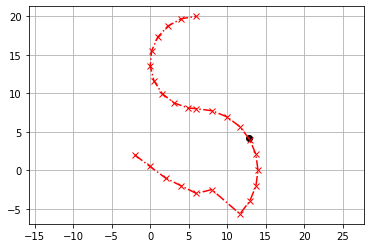

In [9]:
probe_s = my_curve.tot_dist*0.5
print(f"Now, we are testing some query points around the curve at t = {probe_s:.2f} m (see the black dot in the plot).")
plt.plot(*my_curve.get_pos(probe_s).T,'ok')

plt.plot(*my_waypoints.T,'-.xr')
plt.axis('equal')
plt.grid()

plt.show()


In [10]:
my_curve.get_pos(20.0)

array([[13.57, -2.56]])

Test cases 1a
------------------------------
finished iteration 0 with new iterate 27.258
finished iteration 1 with new iterate 26.504
finished iteration 2 with new iterate 26.728
finished iteration 3 with new iterate 26.661
finished iteration 4 with new iterate 26.681
finished iteration 5 with new iterate 26.675
finished iteration 6 with new iterate 26.677
init guess: 20.00, final iterate: 26.68, (signed) projected distance: -2.30, took 0.79 msec
------------------------------
finished iteration 0 with new iterate 26.875
finished iteration 1 with new iterate 26.617
finished iteration 2 with new iterate 26.694
finished iteration 3 with new iterate 26.671
finished iteration 4 with new iterate 26.678
finished iteration 5 with new iterate 26.676
init guess: 26.00, final iterate: 26.68, (signed) projected distance: -2.30, took 0.39 msec
------------------------------
finished iteration 0 with new iterate 25.681
finished iteration 1 with new iterate 26.966
finished iteration 2 with new iter

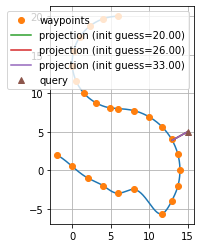

In [11]:
# some query point around that probed point
print("Test cases 1a")
print("-"*30)
test_query = [15.0,5.0] # RHS of the curve
init_guess_list = (20.0, 26.0 , 33.0)
res_Frenet = test_projection(
    path_obj=my_curve,
    projection_method="project",
    test_query_pt= test_query, 
    expected_LHS = False,
    init_guess_list = init_guess_list,
    verbose=True, soln_tolerance=0.005, iter_max=10 # <--- args to the projection algorithm
)
viz_projection(my_curve,test_query_pt=test_query,init_guess_list=init_guess_list, result_Frenet=res_Frenet)
plt.show()

Test cases 1b
------------------------------
finished iteration 0 with new iterate 25.658
finished iteration 1 with new iterate 28.830
finished iteration 2 with new iterate 29.592
finished iteration 3 with new iterate 29.744
finished iteration 4 with new iterate 29.774
finished iteration 5 with new iterate 29.779
finished iteration 6 with new iterate 29.781
init guess: 20.00, final iterate: 29.78, (signed) projected distance: 1.60, took 1.5 msec
------------------------------
finished iteration 0 with new iterate 28.930
finished iteration 1 with new iterate 29.612
finished iteration 2 with new iterate 29.748
finished iteration 3 with new iterate 29.775
finished iteration 4 with new iterate 29.780
finished iteration 5 with new iterate 29.781
init guess: 26.00, final iterate: 29.78, (signed) projected distance: 1.60, took 0.61 msec
------------------------------
finished iteration 0 with new iterate 30.514
finished iteration 1 with new iterate 29.920
finished iteration 2 with new iterate

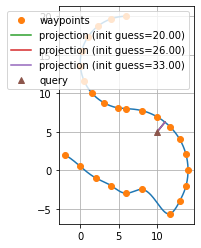

In [12]:
# some query point around that probed point
print("Test cases 1b")
print("-"*30)
test_query = [10.0,5.0] # now the LHS of the curve
init_guess_list = (20.0, 26.0 , 33.0) # same as test cases 1a
res_Frenet = test_projection(
    path_obj=my_curve,
    projection_method="project",
    test_query_pt= test_query, 
    expected_LHS = True,
    init_guess_list = init_guess_list,
    verbose=True, soln_tolerance=0.005, iter_max=10 # <--- args to the projection algorithm
)
viz_projection(my_curve,test_query_pt=test_query,init_guess_list=init_guess_list, result_Frenet=res_Frenet)
plt.show()
    

## Testing case 2

Test cases 2
------------------------------
finished iteration 0 with new iterate 40.787
finished iteration 1 with new iterate 43.965
finished iteration 2 with new iterate 45.354
finished iteration 3 with new iterate 45.807
finished iteration 4 with new iterate 45.947
finished iteration 5 with new iterate 45.990
finished iteration 6 with new iterate 46.003
finished iteration 7 with new iterate 46.007
init guess: 33.00, final iterate: 46.01, (signed) projected distance: -1.89, took 1.5 msec
------------------------------
finished iteration 0 with new iterate 45.367
finished iteration 1 with new iterate 45.811
finished iteration 2 with new iterate 45.948
finished iteration 3 with new iterate 45.990
finished iteration 4 with new iterate 46.003
finished iteration 5 with new iterate 46.007
init guess: 44.00, final iterate: 46.01, (signed) projected distance: -1.89, took 0.7 msec
------------------------------
finished iteration 0 with new iterate 56.433
finished iteration 1 with new iterate

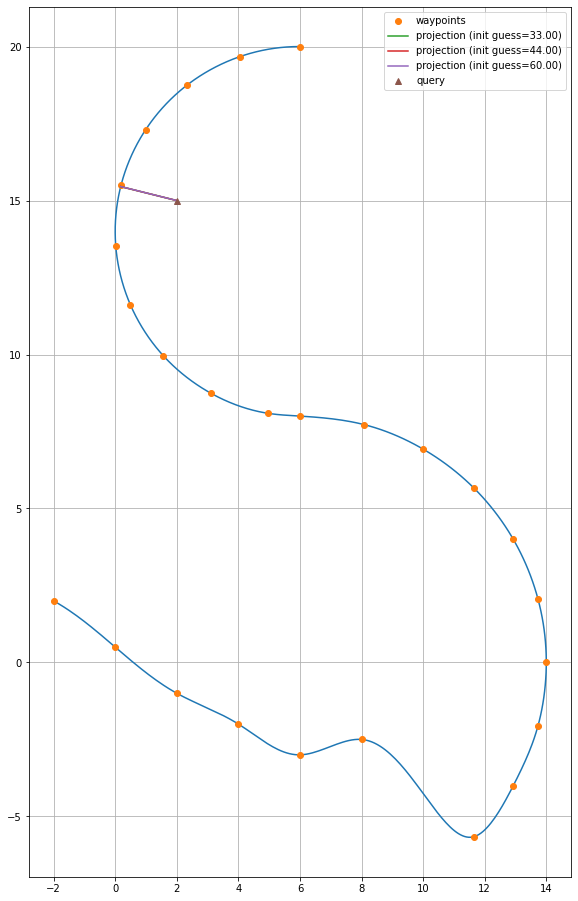

In [13]:
print("Test cases 2")
print("-"*30)
test_query = [2.0, 15.0] # now the LHS of the curve
init_guess_list = (33.0, 44.0, 60.0) # same as test cases 1a
res_Frenet = test_projection(
    path_obj=my_curve,
    projection_method="project",
    test_query_pt= test_query, 
    expected_LHS = False,
    init_guess_list = init_guess_list,
    verbose=True, soln_tolerance=0.005, iter_max=10 # <--- args to the projection algorithm
)
_ , ax = plt.subplots(figsize=(12,16))
viz_projection(my_curve,test_query_pt=test_query,init_guess_list=init_guess_list, result_Frenet=res_Frenet,ax=ax)
plt.show()